In [1]:
import urllib.request

import torch

import torch.nn as nn
import tqdm

import numpy as np
import cv2

import cv2
import imageio
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm
from torch import nn
import matplotlib.pyplot as plt

from models.vectormapconv.vectormap_layers import VectorMapConv, VectorMapBatchNorm2d

def tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor * 256
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    tensor = tensor.type(torch.uint8).permute(1, 2, 0).cpu().numpy()

    return tensor

def get_image():
    image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
    img = imageio.imread(image_url)[..., :3] / 255.
    c = [img.shape[0] // 2, img.shape[1] // 2]
    r = 256
    img = img[c[0] - r:c[0] + r, c[1] - r:c[1] + r]

    return img

cuda


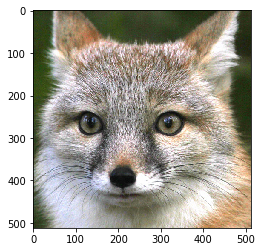

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Get an image that will be the target for our model.
target = torch.tensor(get_image()).unsqueeze(0).permute(0, 3, 1, 2).to(device)
plt.imshow(tensor_to_numpy(target[0]))
plt.show()

# Create input pixel coordinates in the unit square. This will be the input to the model.
coords = np.linspace(0, 1, target.shape[2], endpoint=False)
xy_grid = np.stack(np.meshgrid(coords, coords), -1)
xy_grid = torch.tensor(xy_grid).unsqueeze(0).permute(0, 3, 1, 2).float().contiguous().to(device)

Epoch 0, loss = 0.249


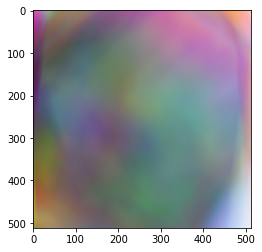

Epoch 100, loss = 0.112


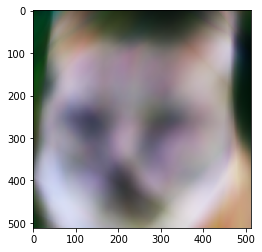

Epoch 200, loss = 0.091


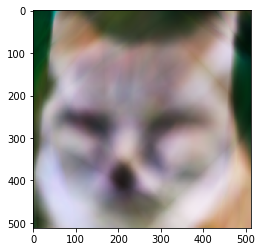

Epoch 300, loss = 0.079


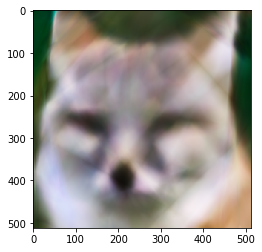

In [3]:
model = nn.Sequential(
        nn.Conv2d(
            2,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            3,
            kernel_size=1,
            padding=0),
        nn.Sigmoid(),

    ).to(device)

optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-4)

for epoch in tqdm(range(400)):
    optimizer.zero_grad()

    generated = model(xy_grid)

    loss = torch.nn.functional.l1_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(tensor_to_numpy(generated[0]))
      plt.show()

In [4]:
class GaussianFourierFeatureTransform(torch.nn.Module):
    """
    An implementation of Gaussian Fourier feature mapping.

    "Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains":
       https://arxiv.org/abs/2006.10739
       https://people.eecs.berkeley.edu/~bmild/fourfeat/index.html

    Given an input of size [batches, num_input_channels, width, height],
     returns a tensor of size [batches, mapping_size*2, width, height].
    """

    def __init__(self, num_input_channels, mapping_size=256, scale=10):
        super().__init__()

        self._num_input_channels = num_input_channels
        self._mapping_size = mapping_size
        self._B = torch.randn((num_input_channels, mapping_size)) * scale

    def forward(self, x):
        assert x.dim() == 4, 'Expected 4D input (got {}D input)'.format(x.dim())

        batches, channels, width, height = x.shape

        assert channels == self._num_input_channels,\
            "Expected input to have {} channels (got {} channels)".format(self._num_input_channels, channels)

        # Make shape compatible for matmul with _B.
        # From [B, C, W, H] to [(B*W*H), C].
        x = x.permute(0, 2, 3, 1).reshape(batches * width * height, channels)

        x = x @ self._B.to(x.device)

        # From [(B*W*H), C] to [B, W, H, C]
        x = x.view(batches, width, height, self._mapping_size)
        # From [B, W, H, C] to [B, C, W, H]
        x = x.permute(0, 3, 1, 2)

        x = 2 * np.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=1)

Epoch 0, loss = 0.242


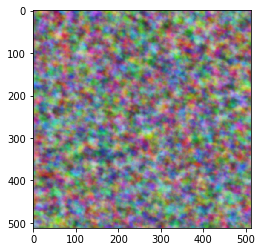

Epoch 100, loss = 0.074


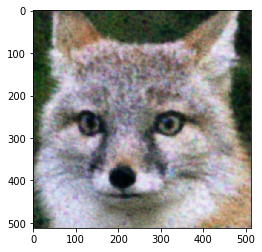

Epoch 200, loss = 0.053


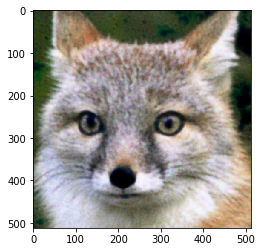

Epoch 300, loss = 0.045


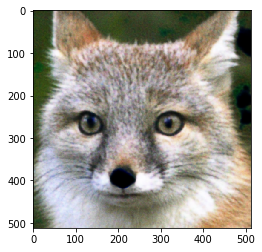

In [5]:
model = nn.Sequential(
        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            3,
            kernel_size=1,
            padding=0),
        nn.Sigmoid(),

    ).to(device)

# Note: this can be done outside of the training loop, since the result at this stage is unchanged during the course of training.
x = GaussianFourierFeatureTransform(2, 128, 10)(xy_grid)

optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-4)

for epoch in tqdm(range(400)):
    optimizer.zero_grad()

    generated = model(x)

    loss = torch.nn.functional.l1_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(tensor_to_numpy(generated[0]))
      plt.show()

Epoch 0, loss = 0.315


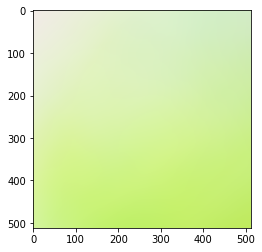

Epoch 100, loss = 0.141


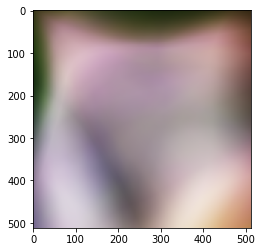

Epoch 200, loss = 0.112


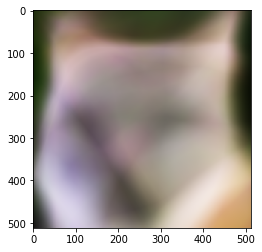

Epoch 300, loss = 0.103


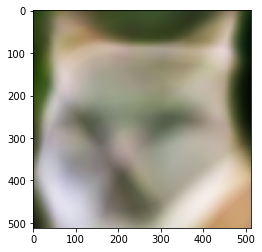

Epoch 400, loss = 0.104


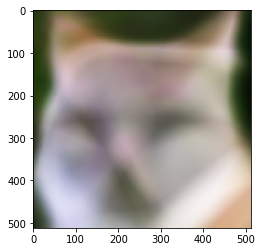

Epoch 500, loss = 0.098


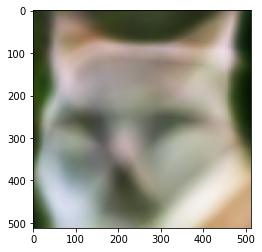

Epoch 600, loss = 0.098


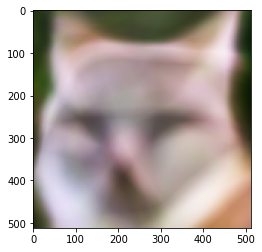

Epoch 700, loss = 0.091


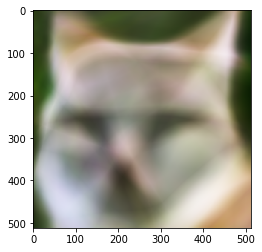

Epoch 800, loss = 0.088


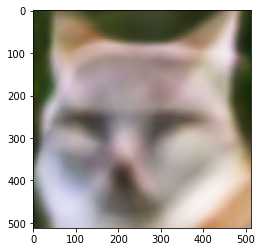

Epoch 900, loss = 0.087


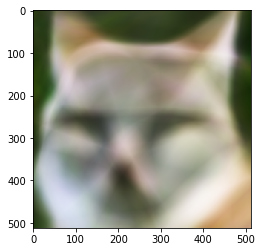

Epoch 1000, loss = 0.087


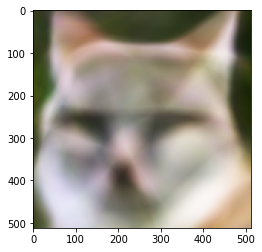

In [3]:
model = nn.Sequential(
        VectorMapConv(
            2,
            2,
            240,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        VectorMapBatchNorm2d(2, 240),

        VectorMapConv(
            3,
            240,
            240,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        VectorMapBatchNorm2d(3, 240),

        VectorMapConv(
            3,
            240,
            240,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        VectorMapBatchNorm2d(3, 240),

        VectorMapConv(
            3,
            240,
            240,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        VectorMapBatchNorm2d(3, 240),

        VectorMapConv(
            3,
            240,
            3,
            kernel_size=1,
            padding=0),
        nn.Sigmoid(),

    ).to(device)

optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3)

for epoch in tqdm(range(1001)):
    optimizer.zero_grad()

    generated = model(xy_grid)

    loss = torch.nn.functional.l1_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(tensor_to_numpy(generated[0]))
      plt.show()